In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [13]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables
Station = Base.classes.station
Measurement = Base.classes.measurement
Base.prepare(engine, reflect=True)

/var/folders/pz/00gws8j51tb1wdx_nb0m97z80000gn/T/ipykernel_23318/4118200497.py:8: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base.prepare(engine, reflect=True)
/var/folders/pz/00gws8j51tb1wdx_nb0m97z80000gn/T/ipykernel_23318/4118200497.py:8: SAWarning: This declarative base already contains a class with the same class name and module name as sqlalchemy.ext.automap.measurement, and will be replaced in the string-lookup table.
  Base.prepare(engine, reflect=True)
/var/folders/pz/00gws8j51tb1wdx_nb0m97z80000gn/T/ipykernel_23318/4118200497.py:8: SAWarning: This declarative base

In [16]:
# View all of the classes that automap found
all_classes = Base.classes.keys()
print("All classes found:", all_classes)

# Create our session (link) from Python to the DB
session = Session(engine)

All classes found: ['measurement', 'station']


In [18]:
# Save references to each table
first_station = session.query(Station).first()
print(first_station.__dict__)

first_measurement = session.query(Measurement).first()
print(first_measurement.__dict__)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x125be3990>, 'latitude': 21.2716, 'id': 1, 'elevation': 3.0, 'name': 'WAIKIKI 717.2, HI US', 'longitude': -157.8168, 'station': 'USC00519397'}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x1743ad690>, 'tobs': 65.0, 'id': 1, 'date': '2010-01-01', 'station': 'USC00519397', 'prcp': 0.08}


# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"The most recent date in the dataset is: {most_recent_date[0]}")

The most recent date in the dataset is: 2017-08-23


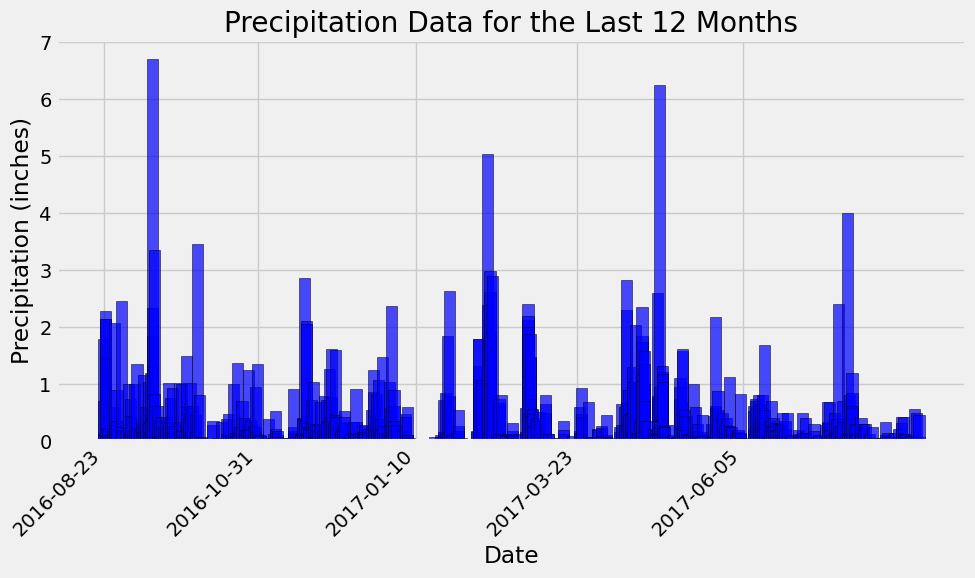

In [59]:
# Find the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the most recent date
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)

# Convert Timestamp to string
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores for the last 12 months
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago_str)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame values by "date"
precipitation_df.sort_values('Date', inplace=True)

# Extract year from the "Date" column
precipitation_df['Year'] = pd.to_datetime(precipitation_df['Date']).dt.year
# Extract month, day, and year for better visibility
precipitation_df['Formatted_Date'] = pd.to_datetime(precipitation_df['Date']).dt.strftime('%Y-%m-%d')

# Select every nth date for better visibility (adjust n as needed)
n = len(precipitation_df) // 5  # Adjust to show five dates

# Plot the results using the DataFrame plot method
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], width=5, color='blue', alpha=0.7, edgecolor='black')
plt.title('Precipitation Data for the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')

# Show only five dates on the x-axis with month, day, and year
plt.xticks(rotation=45, ha='right', ticks=precipitation_df['Date'][::n], labels=precipitation_df['Formatted_Date'][::n])

plt.tight_layout()
plt.show()



In [30]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Calculate summary statistics for precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()

# Display the summary statistics
print(summary_statistics)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations
total_stations = session.query(func.count(func.distinct(Station.station))).scalar()

# Display the total number of stations
print(f'Total number of stations: {total_stations}')


Total number of stations: 9


In [33]:
# Design a query to find the most active stations
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

# Display the most active stations and their counts
for station, count in active_stations:
    print(f'Station: {station}, Count: {count}')


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [34]:
# Find the most active station
most_active_station = session.query(Measurement.station)\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .first()

# Unpack the result tuple to get the station id
most_active_station_id = most_active_station[0]

# Calculate lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station_id)\
    .all()

# Display the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f"Most Active Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


Most Active Station ID: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


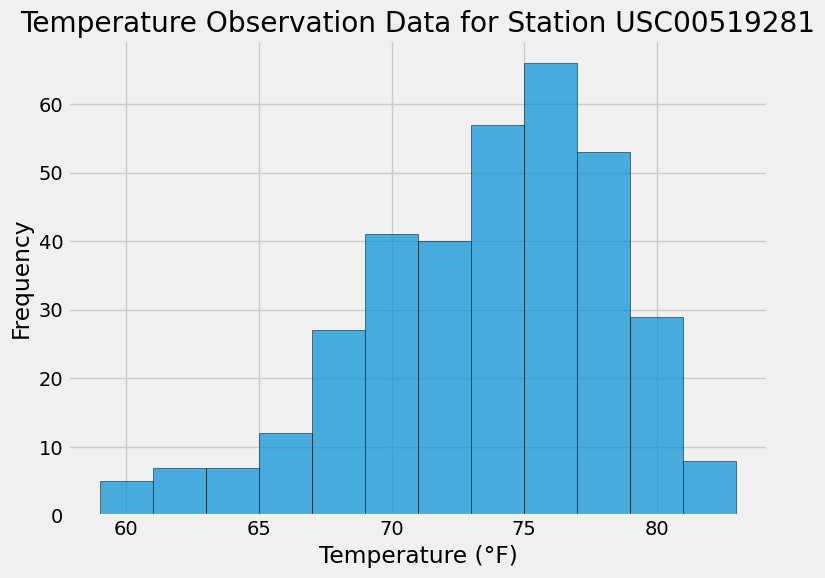

In [35]:
# Query to retrieve the last 12 months of temperature data for the most active station
temperature_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_ago_str)\
    .all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12, edgecolor='black', alpha=0.7)
plt.title(f'Temperature Observation Data for Station {most_active_station_id}')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()